# __Import & config__

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [2]:
import nibabel as nib
import numpy as np
import torch
from tqdm.auto import tqdm

# __Prepare data__

In [3]:
from glob import glob
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

In [4]:
def prepare(
        in_dir,
        pixdim=(1.5, 1.5, 1.0),
        a_min=-200,
        a_max=200,
        spatial_size=[128, 128, 64],
        cache=True
    ):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "train/images", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "train/masks", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "test/images", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "test/masks", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

## __Get dataloaders__

In [15]:
in_dir = "data/prepared/"
train_loader, test_loader = prepare(
    in_dir=in_dir,
    pixdim=(1.5, 1.5, 1.0),
    a_min=-150,
    a_max=250,
    spatial_size=[128, 128, 64],
    cache=False
)

In [17]:
# Check the data
print(len(train_loader))
for batch in train_loader:
    print(batch["vol"].shape)
    print(batch["seg"].shape)
    break
print(len(train_loader))

88
torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 1, 128, 128, 64])
88


In [27]:
batch['vol'].meta

{'scl_inter': tensor([nan]),
 'slice_duration': tensor([0.]),
 'srow_z': tensor([[  0.0000,   0.0000,   1.0109, 763.5217]]),
 'quatern_c': tensor([0.]),
 'sizeof_hdr': tensor([348], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'as_closest_canonical': tensor([False]),
 'quatern_d': tensor([1.]),
 'vox_offset': tensor([0.]),
 'extents': tensor([0], dtype=torch.int32),
 'intent_p3': tensor([0.]),
 'slice_start': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'scl_slope': tensor([nan]),
 'glmin': tensor([0], dtype=torch.int32),
 space: [RAS],
 'cal_max': tensor([0.]),
 'intent_p2': tensor([0.]),
 'toffset': tensor([0.]),
 'qoffset_y': tensor([81.]),
 'quatern_b': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 affine: tensor([[[   3.0000,    0.0000,    0.0000, -168.7500],
          [   0.0000,    2.9883,    0.0000, -300.7559],
          [   0.0000,    0.0000,    1.4375,  763.7405],
          [   0.0000,    0.0000,    0.0000,

In [10]:
# Visualize the data (one slice)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import nibabel as nib
import numpy as np
import os

def plot_slices(image, mask, slice_index=0):
    """
    Plot the slices of the image and mask at the given slice index.
    """
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    ax0.imshow(image[:, :, slice_index], cmap='gray')
    ax0.set_title('Image Slice')

    ax1.imshow(mask[:, :, slice_index], cmap='gray')
    ax1.set_title('Mask Slice')

    plt.show()

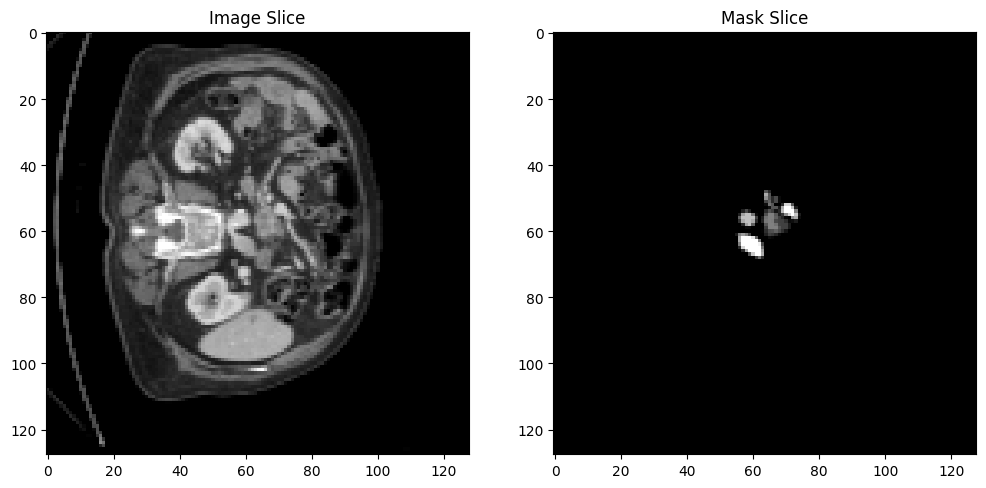

In [18]:
plot_slices(
    batch["vol"].numpy()[0, 0],
    batch["seg"].numpy()[0, 0],
    slice_index=20
)

# __Utils__

In [19]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm.auto import tqdm

In [20]:
def dice_metric(predicted, target):
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

# __Train__

In [21]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch

In [23]:
data_dir = "data/prepared/"
model_dir = "test_monai/" 
data_in = prepare(data_dir, a_min=-150, a_max=250, cache=False)

device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

c:\Users\Usuario\miniconda3\envs\pancreas-segmentation\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [25]:
os.makedirs(model_dir, exist_ok=True)
train(model, data_in, loss_function, optimizer, 100, model_dir, device=device)

----------
epoch 1/100
1/88, Train_loss: 0.8256
Train_dice: 0.1744
2/88, Train_loss: 0.8184
Train_dice: 0.1816
3/88, Train_loss: 0.8199
Train_dice: 0.1801
4/88, Train_loss: 0.8192
Train_dice: 0.1808
5/88, Train_loss: 0.8215
Train_dice: 0.1785
6/88, Train_loss: 0.8216
Train_dice: 0.1784
7/88, Train_loss: 0.8219
Train_dice: 0.1781
8/88, Train_loss: 0.8182
Train_dice: 0.1818
9/88, Train_loss: 0.8192
Train_dice: 0.1808
10/88, Train_loss: 0.8162
Train_dice: 0.1838
11/88, Train_loss: 0.8210
Train_dice: 0.1790
12/88, Train_loss: 0.8198
Train_dice: 0.1802
13/88, Train_loss: 0.8238
Train_dice: 0.1762
14/88, Train_loss: 0.8158
Train_dice: 0.1842
15/88, Train_loss: 0.8201
Train_dice: 0.1799
16/88, Train_loss: 0.8208
Train_dice: 0.1792
17/88, Train_loss: 0.8224
Train_dice: 0.1776
18/88, Train_loss: 0.8193
Train_dice: 0.1807
19/88, Train_loss: 0.8214
Train_dice: 0.1786
20/88, Train_loss: 0.8211
Train_dice: 0.1789
21/88, Train_loss: 0.8171
Train_dice: 0.1829
22/88, Train_loss: 0.8179
Train_dice: 0.1

KeyboardInterrupt: 